<a href="https://colab.research.google.com/github/oluwafemidiakhoa/Mindserach/blob/master/Weather_RoadNg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os

# Define the paths to the zip files and the directory to extract them to
zip_file_path_weather = '/content/Nigeria_weather.zip'
zip_file_path_traffic = '/content/Nigerian.zip'
extract_dir_weather = '/content/Nigeria_weather_data/'
extract_dir_traffic = '/content/Nigerian_data/'

# Extract the contents of the weather zip file
with zipfile.ZipFile(zip_file_path_weather, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_weather)

# Extract the contents of the traffic zip file
with zipfile.ZipFile(zip_file_path_traffic, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_traffic)

# List the extracted files from both zip files
extracted_files_weather = os.listdir(extract_dir_weather)
extracted_files_traffic = os.listdir(extract_dir_traffic)

extracted_files_weather, extracted_files_traffic


(['nigeria_cities_weather_data.csv'],
 ['Nigerian_Road_Traffic_Crashes_2020_2024.csv'])

In [7]:
import pandas as pd

# Load both datasets
weather_data_path = '/content/Nigeria_weather_data/nigeria_cities_weather_data.csv'
crash_data_path = '/content/Nigerian_data/Nigerian_Road_Traffic_Crashes_2020_2024.csv'

# Load datasets into pandas dataframes
weather_df = pd.read_csv(weather_data_path)
crash_df = pd.read_csv(crash_data_path)

# Display basic info and a few rows of both datasets to understand their structure
weather_df_info = weather_df.info()
crash_df_info = crash_df.info()

# Displaying the first few rows of both datasets
weather_df_head = weather_df.head()
crash_df_head = crash_df.head()

print(weather_df_info, crash_df_info)
print(weather_df_head, crash_df_head)

# Map cities to states using the 'region' column in the weather dataset
weather_df['State'] = weather_df['region']  # Renaming 'region' to 'State' to align with crash data

# Convert 'date' column in weather data to datetime format and extract the quarter for aggregation
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['Quarter'] = weather_df['date'].dt.to_period('Q')

# Aggregate weather data by State and Quarter, calculating mean values for weather metrics
weather_aggregated = weather_df.groupby(['State', 'Quarter']).agg({
    'temp': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'cloud': 'mean'
}).reset_index()

# Standardize the quarter format to match the crash data
weather_aggregated['Quarter'] = weather_aggregated['Quarter'].astype(str)
weather_aggregated['Quarter'] = weather_aggregated['Quarter'].str.replace('2024Q1', 'Q1 2024')

# Filter the crash data to include only the states available in the weather dataset
crash_filtered_df = crash_df[crash_df['State'].isin(weather_aggregated['State'].unique())]

# Merge the crash data with the aggregated weather data on 'State' and 'Quarter'
combined_df = pd.merge(crash_filtered_df, weather_aggregated, on=['State', 'Quarter'], how='inner')

# Display the combined dataset
print(combined_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22541 entries, 0 to 22540
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       22541 non-null  object 
 1   city          22541 non-null  object 
 2   latitude      22541 non-null  float64
 3   longitude     22541 non-null  float64
 4   temp          22541 non-null  float64
 5   temp_min      22541 non-null  float64
 6   temp_max      22541 non-null  float64
 7   pressure      22541 non-null  int64  
 8   humidity      22541 non-null  int64  
 9   sea_level     22541 non-null  int64  
 10  ground_level  22541 non-null  int64  
 11  wind_speed    22541 non-null  float64
 12  wind_degree   22541 non-null  int64  
 13  sunrise       22541 non-null  object 
 14  sunset        22541 non-null  object 
 15  timezone      22541 non-null  int64  
 16  cloud         22541 non-null  int64  
 17  description   22541 non-null  object 
 18  region        22541 non-nu

In [8]:
# Importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for modeling
X = combined_df[['temp', 'humidity', 'wind_speed', 'cloud']]  # Weather features
y = combined_df['Total_Crashes']  # Target variable: crashes

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


Mean Squared Error: 5171.646500000001
R2 Score: -826.4634400000001


In [9]:
# LSTM for time series forecasting
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Prepare the data for LSTM (reshaping to 3D)
X = combined_df[['temp', 'humidity', 'wind_speed', 'cloud']].values
y = combined_df['Total_Crashes'].values

X = X.reshape((X.shape[0], 1, X.shape[1]))  # LSTM expects 3D data

# Create an LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)

# Forecast future crashes (after training)
y_forecast = model.predict(X)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 11753.4150
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 11596.7900
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 11438.5117
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 11275.5156
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 11105.3125
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 10926.2607
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 10737.8311
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 10540.6924
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 10336.4785
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 10127.3955
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 9915.8721
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 9704.4570
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 9495.7773
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 9292.3154
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step -

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.1 MB/s eta 0:00:00


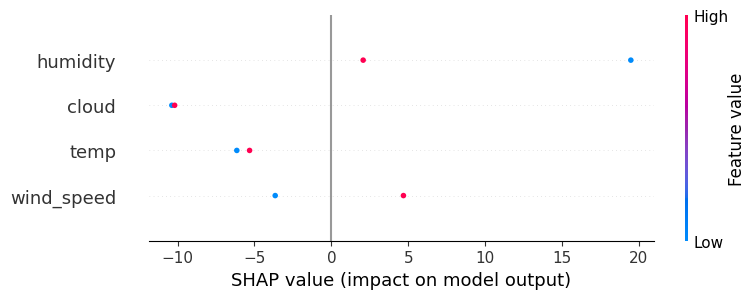

In [11]:
# SHAP for model interpretation
!pip install shap
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)


In [12]:
# Risk scoring system based on real-time weather data
def risk_score(temp, humidity, wind_speed, cloud):
    # Simplified risk score calculation based on weather conditions
    score = temp * 0.4 + humidity * 0.3 + wind_speed * 0.2 + cloud * 0.1
    return score

# Example usage
example_temp = 35  # degrees Celsius
example_humidity = 60  # percentage
example_wind_speed = 10  # m/s
example_cloud = 80  # percentage

print("Risk Score:", risk_score(example_temp, example_humidity, example_wind_speed, example_cloud))


Risk Score: 42.0


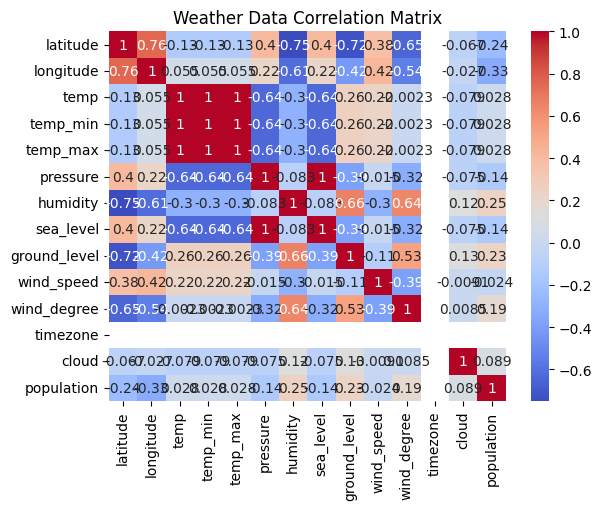

Explained variance ratio: [0.6576863  0.33284051 0.00843327]
Mutual Information between features and crash data: [0.33385529 0.72260201 0.18106185 0.24939579]


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

# Load datasets
weather_data_path = '/content/Nigeria_weather_data/nigeria_cities_weather_data.csv'
crash_data_path = '/content/Nigerian_data/Nigerian_Road_Traffic_Crashes_2020_2024.csv'

weather_df = pd.read_csv(weather_data_path)
crash_df = pd.read_csv(crash_data_path)

# Merge datasets based on city and state
# Convert city and state to lowercase for matching consistency
weather_df['city'] = weather_df['city'].str.lower()
crash_df['State'] = crash_df['State'].str.lower()

merged_df = pd.merge(weather_df, crash_df, left_on='city', right_on='State', how='inner')

# Extract features (X) and target variable (y)
X = merged_df[['temp', 'humidity', 'wind_speed', 'cloud']]
y = merged_df['Total_Crashes']

# Perform exploratory data analysis (EDA) on the merged dataset
numeric_weather_df = weather_df.select_dtypes(include='number')

# Correlation matrix for weather data
sns.heatmap(numeric_weather_df.corr(), annot=True, cmap='coolwarm')
plt.title('Weather Data Correlation Matrix')
plt.show()

# PCA for dimensionality reduction
pca = PCA(n_components=3)
weather_pca = pca.fit_transform(X)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Feature importance using mutual information regression
# Make sure X and y have the same length
min_length = min(len(X), len(y))
X = X.iloc[:min_length]
y = y.iloc[:min_length]

mutual_info = mutual_info_regression(X, y)
print(f"Mutual Information between features and crash data: {mutual_info}")


In [20]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for modeling
X = combined_df[['temp', 'humidity', 'wind_speed', 'cloud']]
y = combined_df['Total_Crashes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5)
xgb_model.fit(X_train, y_train)

# Evaluate model
y_pred = xgb_model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")




RMSE: 91.44083584978024
R2 Score: -1336.828233745033


In [21]:
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Data preparation for Transformer
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define a simple Transformer model for time-series prediction
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, num_heads, num_encoder_layers, num_decoder_layers):
        super(TimeSeriesTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=input_size, nhead=num_heads,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers)
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.transformer(x, x)
        return self.fc(out[-1])

# Model parameters and training
input_size = X_scaled.shape[1]
model = TimeSeriesTransformer(input_size, num_heads=4, num_encoder_layers=2, num_decoder_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified for brevity)
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(torch.tensor(X_scaled).float())
    loss = criterion(outputs, torch.tensor(y).float())
    loss.backward()
    optimizer.step()

print(f"Final Training Loss: {loss.item()}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Final Training Loss: 9969.1708984375


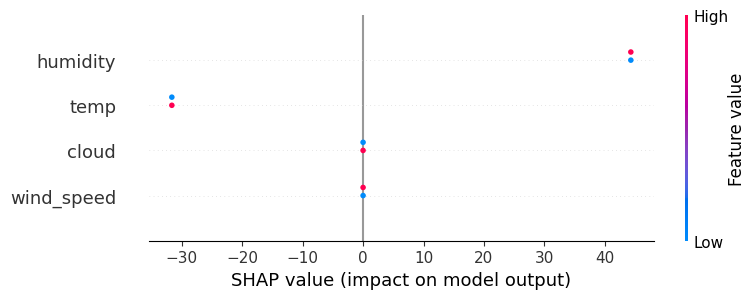

In [22]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [23]:
# Simple real-time risk scoring function
def risk_score(temp, humidity, wind_speed, cloud):
    score = 0.4 * temp + 0.3 * humidity + 0.2 * wind_speed + 0.1 * cloud
    return score

# Example real-time weather conditions
current_weather = {'temp': 32, 'humidity': 70, 'wind_speed': 12, 'cloud': 85}
score = risk_score(**current_weather)
print(f"Current Risk Score: {score}")


Current Risk Score: 44.699999999999996
